In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import csv

with open('data/train.csv', 'r') as train_file:
    train_reader = csv.reader(train_file)
    train_data = list(train_reader)

with open('data/test.csv', 'r') as test_file:
    test_reader = csv.reader(test_file)
    test_data = list(test_reader)




In [3]:
print(np.array(test_data))
X_labels = test_data[0][1:]
train_data = [row[:] for row in train_data[1:]]
test_data = [row[:] for row in test_data[1:]]
train_data = [[float(value) for value in row[1:]] for row in train_data]
test_data = [[float(value) for value in row[1:]] for row in test_data]

[['id' 'MonsoonIntensity' 'TopographyDrainage' ... 'WetlandLoss'
  'InadequatePlanning' 'PoliticalFactors']
 ['1117957' '4' '6' ... '4' '4' '5']
 ['1117958' '4' '4' ... '4' '4' '3']
 ...
 ['1863259' '5' '7' ... '5' '5' '4']
 ['1863260' '4' '7' ... '7' '5' '5']
 ['1863261' '4' '2' ... '8' '6' '3']]


In [4]:
train_data = np.array(train_data)
test_data = np.array(test_data)
print(train_data.shape)
print(test_data.shape)
print(test_data)

(1117957, 21)
(745305, 20)
[[4. 6. 3. ... 4. 4. 5.]
 [4. 4. 2. ... 4. 4. 3.]
 [1. 3. 6. ... 6. 8. 3.]
 ...
 [5. 7. 9. ... 5. 5. 4.]
 [4. 7. 6. ... 7. 5. 5.]
 [4. 2. 5. ... 8. 6. 3.]]


In [5]:
import random

# Shuffle the training data
random.shuffle(train_data)

# Calculate the split index
split_index = int(len(train_data) * 0.7)  # 70% for training, 30% for cross-validation

# Split the data
x_train = np.array([row[:-1] for row in train_data[:split_index]])
y_train = np.array([row[-1] for row in train_data[:split_index]])
x_cv = np.array([row[:-1] for row in train_data[split_index:]])
y_cv = np.array([row[-1] for row in train_data[split_index:]])

In [6]:

class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self

    def transform(self, X):
        return (X - self.mean_) / self.std_

# Fit the scaler on the training data
scaler = StandardScaler().fit(x_train)

# Transform the training and cross-validation data
x_train = torch.Tensor(scaler.transform(x_train))
x_cv = torch.Tensor(scaler.transform(x_cv))

In [7]:

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).unsqueeze(1)
x_cv = torch.Tensor(x_cv)
y_cv = torch.Tensor(y_cv).unsqueeze(1)
print(x_train.shape)
print(y_train.shape)

torch.Size([782569, 20])
torch.Size([782569, 1])


In [8]:
class floodProb(nn.Module):
    def __init__(self):
        '''Populate with the layers of the model'''
        super(floodProb,self).__init__()

        # define layers
        self.input = nn.Linear(in_features=20,out_features=10)
        self.hidden1 = nn.Linear(10,5)
        self.output = nn.Linear(5,1)

    def forward(self,x):
        '''Operations that are taking place in the layers'''

        # input
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        # output
        x = self.output(x)

        return x

In [9]:

def create_model(lr,lossfun):
    model = floodProb()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lossfun = torch.nn.MSELoss()  
    return model, lossfun, optimizer

In [14]:
def train(model, lossfun, optimizer, inputs, targets, batch_size=32, epochs=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    num_samples = inputs.shape[0]
    num_batches = num_samples // batch_size

    inputs_device = torch.zeros_like(inputs, device=device)
    targets_device = torch.zeros_like(targets, device=device)

    kwargs = {'num_workers': 4, 'pin_memory': True} if device.type == 'cuda' else {}
    train_dataset = torch.utils.data.TensorDataset(inputs, targets)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

    losses = torch.zeros(epochs, device=device)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for batch_idx, (batch_inputs, batch_targets) in enumerate(train_loader):
            inputs_device[:batch_inputs.size(0)] = batch_inputs
            targets_device[:batch_targets.size(0)] = batch_targets
            
            optimizer.zero_grad()
            outputs = model(inputs_device)
            loss = lossfun(outputs, targets_device)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if batch_idx % 10 == 0:  # Reduce print frequency
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{num_batches}], Loss: {loss.item():.4f}", end="\r")
        
        losses[epoch] = epoch_loss / num_batches
        print(f"\nEpoch [{epoch+1}/{epochs}] completed, Average Loss: {losses[epoch]:.4f}")
    
    return losses.cpu().numpy()

In [13]:
 # Set seed for reproducibility
epochs = 100
lr = 0.06
model = floodProb()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
model.train()
losses = train(model, nn.MSELoss(), optimizer, x_train, y_train,epochs=epochs,batch_size=1028)
    
model.eval()
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    x_cv = x_cv.to(device)
    outputs = model(x_cv)
    loss_function = nn.MSELoss()
    y_cv = y_cv.to(device)
    loss = loss_function(outputs, y_cv)
print(losses)

Epoch [1/100], Batch [761/761], Loss: 0.0000
Epoch [1/100] completed, Average Loss: 0.0001
Epoch [2/100], Batch [761/761], Loss: 0.0000
Epoch [2/100] completed, Average Loss: 0.0000
Epoch [3/100], Batch [761/761], Loss: 0.0000
Epoch [3/100] completed, Average Loss: 0.0000
Epoch [4/100], Batch [761/761], Loss: 0.0000
Epoch [4/100] completed, Average Loss: 0.0000
Epoch [5/100], Batch [761/761], Loss: 0.0000
Epoch [5/100] completed, Average Loss: 0.0000
Epoch [6/100], Batch [761/761], Loss: 0.0000
Epoch [6/100] completed, Average Loss: 0.0000
Epoch [7/100], Batch [761/761], Loss: 0.0000
Epoch [7/100] completed, Average Loss: 0.0000
Epoch [8/100], Batch [761/761], Loss: 0.0000
Epoch [8/100] completed, Average Loss: 0.0000
Epoch [9/100], Batch [761/761], Loss: 0.0000
Epoch [9/100] completed, Average Loss: 0.0000
Epoch [10/100], Batch [761/761], Loss: 0.0000
Epoch [10/100] completed, Average Loss: 0.0000
Epoch [11/100], Batch [761/761], Loss: 0.0000
Epoch [11/100] completed, Average Loss: 0.

In [ ]:

 # Set seed for reproducibility
epochs = 2
num_lr = 100
lrs = np.linspace(0.01, 0.1, 100)
all_losses = np.zeros((epochs, num_lr))
all_cv = np.zeros((1, num_lr))

for idx, lr in enumerate(lrs):
    model = floodProb()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    if idx == 0:
        initial_state = copy.deepcopy(model.state_dict())
    else:
        model.load_state_dict(copy.deepcopy(initial_state))
    model.train()
    losses = train(model, nn.MSELoss(), optimizer, x_train, y_train,epochs=epochs,batch_size=1028)
    
    model.eval()
    with torch.no_grad():
        outputs = model(x_cv)
        loss_cv = nn.MSELoss()(outputs, y_cv)
        
    all_cv[0, idx] = loss_cv.item()
    all_losses[:, idx] = losses

(Text(0.5, 0, 'Learning rate'), Text(0, 0.5, 'Loss on Dev'))

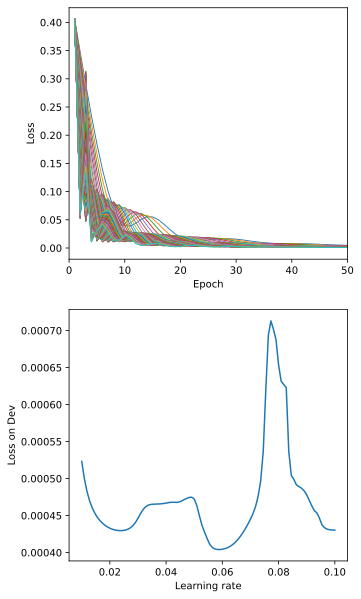

In [215]:
# show the losses
fig,ax = plt.subplots(2,figsize=(5,10), gridspec_kw={'height_ratios': [1, 1]})
for idx,lr in enumerate(lrs):
    ax[0].plot(range(1,201),all_losses[:,idx],'-',markerfacecolor='w',linewidth=.9,label=f"{np.round(lr,3)}")
    ax[0].set_xlim((0,50))
    ax[0].set_xlabel('Epoch'), ax[0].set_ylabel('Loss')
ax[1].plot(lrs,all_cv.flatten())
ax[1].set_xlabel('Learning rate'), ax[1].set_ylabel('Loss on Dev')


(200, 100)


(Text(0.5, 0, 'Learning rate'), Text(0, 0.5, 'Loss on Dev'))

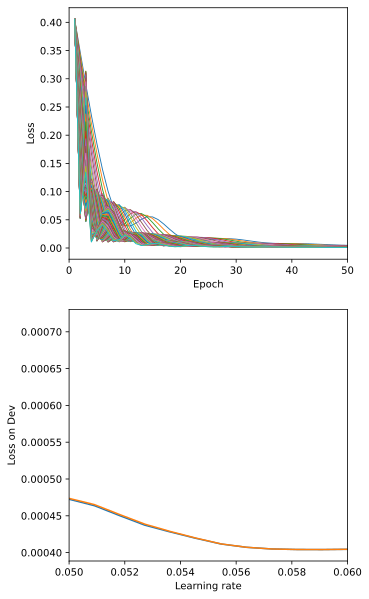

In [229]:
# show the losses
fig,ax = plt.subplots(2,figsize=(5,10), gridspec_kw={'height_ratios': [1, 1]})
for idx,lr in enumerate(lrs):
    ax[0].plot(range(1,201),all_losses[:,idx],'-',markerfacecolor='w',linewidth=.9,label=f"{np.round(lr,3)}")
    ax[0].set_xlim((0,50))
    ax[0].set_xlabel('Epoch'), ax[0].set_ylabel('Loss')
ax[1].plot(lrs,all_cv.flatten())
print(all_losses.shape)
ax[1].plot(lrs[:],all_losses[-1,:])
ax[1].set_xlim((0.05,0.06))
ax[1].set_xlabel('Learning rate'), ax[1].set_ylabel('Loss on Dev')


In [ ]:

lr = 0.02
lossfuns = nn.MSELoss()